In [1]:
!mkdir -p ./kaggle
!cp kaggle.json ~/.kaggle/

cp: cannot stat 'kaggle.json': No such file or directory


In [2]:
!kaggle datasets download -d msambare/fer2013

Dataset URL: https://www.kaggle.com/datasets/msambare/fer2013
License(s): DbCL-1.0
 98% 59.0M/60.3M [00:04<00:00, 20.9MB/s]
100% 60.3M/60.3M [00:04<00:00, 14.0MB/s]


In [3]:
!unzip /content/fer2013.zip -d /content/

Streaming output truncated to the last 5000 lines.
  inflating: /content/train/sad/Training_65242339.jpg  
  inflating: /content/train/sad/Training_65267116.jpg  
  inflating: /content/train/sad/Training_65275626.jpg  
  inflating: /content/train/sad/Training_6529266.jpg  
  inflating: /content/train/sad/Training_65329617.jpg  
  inflating: /content/train/sad/Training_65338712.jpg  
  inflating: /content/train/sad/Training_65338797.jpg  
  inflating: /content/train/sad/Training_65387162.jpg  
  inflating: /content/train/sad/Training_65404494.jpg  
  inflating: /content/train/sad/Training_65426218.jpg  
  inflating: /content/train/sad/Training_65430136.jpg  
  inflating: /content/train/sad/Training_65437377.jpg  
  inflating: /content/train/sad/Training_6545735.jpg  
  inflating: /content/train/sad/Training_65463385.jpg  
  inflating: /content/train/sad/Training_65473985.jpg  
  inflating: /content/train/sad/Training_65502829.jpg  
  inflating: /content/train/sad/Training_65505359.jpg  

In [4]:
# installung the pacakges
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import imghdr
import tensorflow as tf
from PIL import Image
import seaborn as sns

from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.utils.class_weight import compute_class_weight

from tensorflow.keras import layers, models, regularizers, optimizers
from tensorflow.keras.applications import VGG16, ResNet50V2
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TensorBoard, CSVLogger
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Dropout, Flatten, Dense, Activation, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras.utils import plot_model

In [ ]:
# setting up directory to save model data
os.makedirs('test_dir', exist_ok=True)

In [5]:
project_name = 'FER_2013_Emotion_Detection'

# List your models
model_names = [
    'Custom_CNN_From_Scratch',
    'Custom_CNN_With_Augmentation',
    'VGG16_Transfer_Learning',
    'ResNet50_Transfer_Learning'
]

# Base directory (in this case, your Google Colab workspace)
base_dir = '/content/'

# Create the project directory
project_dir = os.path.join(base_dir, project_name)
os.makedirs(project_dir, exist_ok=True)

# Create a subdirectory for each model
for each_model in model_names:
    model_dir = os.path.join(project_dir, each_model)
    os.makedirs(model_dir, exist_ok=True)
    # Example subdirectories for model-related files
    # os.makedirs(os.path.join(model_dir, 'checkpoints'), exist_ok=True)
    # os.makedirs(os.path.join(model_dir, 'logs'), exist_ok=True)
    # os.makedirs(os.path.join(model_dir, 'saved_models'), exist_ok=True)

print(f'Project directory structure created at: {project_dir}')


Project directory structure created at: /content/FER_2013_Emotion_Detection


In [6]:
# now data cleaning aprt
# Define the list of acceptable image extensions
image_exts = ['jpeg', 'jpg', 'png']

# Path to the directory containing image classes and possibly other nested subdirectories
data_dir = '/content/train'

# Walk through all directories and files in the dataset
for root, dirs, files in os.walk(data_dir):
    for file in files:
        # Construct the path to the current file
        file_path = os.path.join(root, file)

        try:
            # Check the file type of the current file
            file_type = imghdr.what(file_path)

            # If the file extension is not in the allowed list, remove it
            if file_type not in image_exts:
                print(f'Image not in ext list {file_path}')
                os.remove(file_path)
            else:
                # Proceed to process the image if needed, for example, reading it with OpenCV
                img = cv2.imread(file_path)

        except Exception as e:
            # Print out the issue and the path of the problematic file
            print(f'Issue with file {file_path}. Error: {e}')
            # Optionally, remove files that cause exceptions
            os.remove(file_path)

In [ ]:
# data analysis part
# Define a function to count the number of files (assumed to be images for this context) for each subdirectory in a given directory.
# The function returns a DataFrame with these counts, indexed by a specified set name (e.g., 'train' or 'test').
def count_files_in_subdirs(directory, set_name):
    # Initialize an empty dictionary to hold the count of files for each subdirectory.
    counts = {}

    # Iterate over each item in the given directory.
    for item in os.listdir(directory):
        # Construct the full path to the item.
        item_path = os.path.join(directory, item)

        # Check if the item is a directory.
        if os.path.isdir(item_path):
            # Count the number of files in the subdirectory and add it to the dictionary.
            counts[item] = len(os.listdir(item_path))

    # Convert the counts dictionary to a DataFrame for easy viewing and analysis.
    # The index of the DataFrame is set to the provided set name.
    df = pd.DataFrame(counts, index=[set_name])
    return df

# Paths to the training and testing directories.
train_dir = '/content/train'
test_dir = '/content/test'

# Count the files in the subdirectories of the training directory and print the result.
train_count = count_files_in_subdirs(train_dir, 'train')
print(train_count)

# Count the files in the subdirectories of the testing directory and print the result.
test_count = count_files_in_subdirs(test_dir, 'test')
print(test_count)

       angry  happy  neutral  disgust  surprise  fear   sad
train   3995   7215     4965      436      3171  4097  4830
      angry  happy  neutral  disgust  surprise  fear   sad
test    958   1774     1233      111       831  1024  1247


<Axes: >

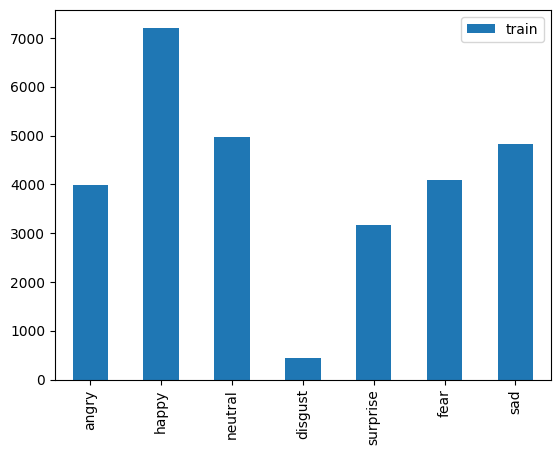

In [ ]:
train_count.transpose().plot(kind='bar')

<Axes: >

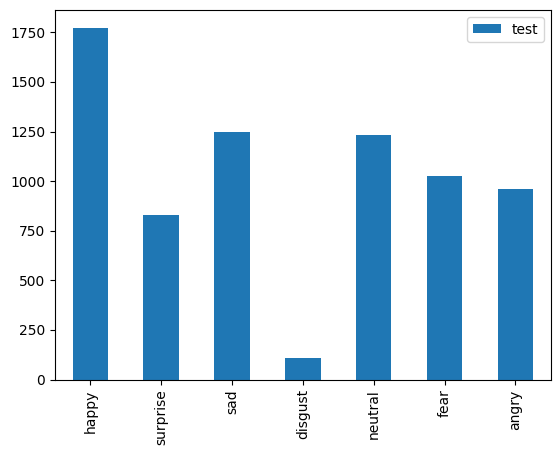

In [ ]:
test_count.transpose().plot(kind = "bar")

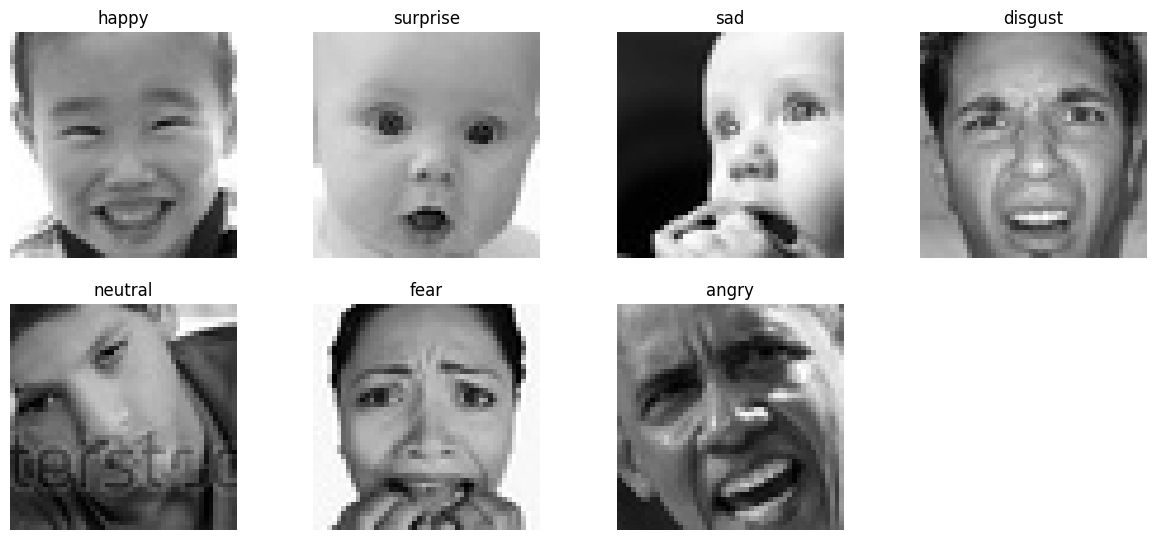

In [ ]:
# plotting one image from each emotion
emotions = os.listdir(train_dir)
plt.figure(figsize=(15,10))

for i, emotion in enumerate(emotions, 1):
    folder = os.path.join(train_dir, emotion)
    img_path = os.path.join(folder, os.listdir(folder)[42])
    img = plt.imread(img_path)
    plt.subplot(3, 4, i)
    plt.imshow(img, cmap='gray')
    plt.title(emotion)
    plt.axis('off')

In [ ]:
# plotting random images from directory
def plot_images_from_directory(directory_path, class_name, num_images=9):
    # Retrieve list of all file names in the directory
    image_filenames = os.listdir(directory_path)

    # If there are fewer images than requested, we'll just show them all
    if len(image_filenames) < num_images:
        print(f"Only found {len(image_filenames)} images in {directory_path}, displaying them all.")
        num_images = len(image_filenames)

    # Randomly select 'num_images' number of file names
    selected_images = random.sample(image_filenames, num_images)

    # Plotting the images
    fig, axes = plt.subplots(3, 3, figsize=(5, 5))  # Adjust the size as needed
    axes = axes.ravel()

    for i, image_file in enumerate(selected_images):
        image_path = os.path.join(directory_path, image_file)
        # image = Image.open(image_path)
        image = load_img(image_path)
        axes[i].imshow(image)
        axes[i].set_title(f"Image: {class_name}")
        axes[i].axis('off')  # Hide the axis

    plt.tight_layout()
    plt.show()

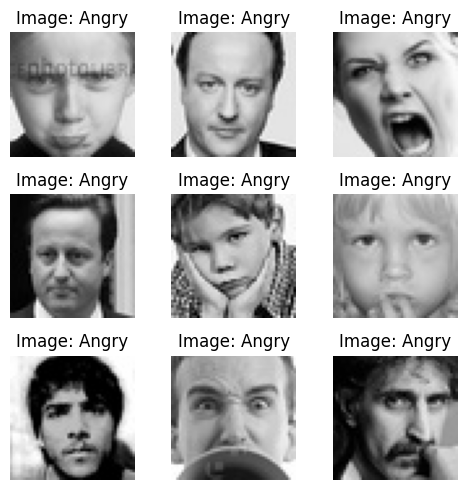

In [ ]:
# Placeholder for the directory path
angry_directory_path = '/content/train/angry'  # Replace with your directory path
plot_images_from_directory(angry_directory_path, class_name = 'Angry')

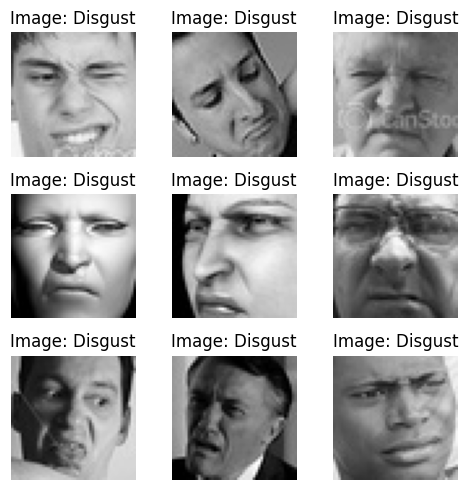

In [ ]:
# Placeholder for the directory path
disgust_directory_path = '/content/train/disgust'  # Replace with your directory path
plot_images_from_directory(disgust_directory_path, class_name = 'Disgust')

In [ ]:
# checking shapes and channels
image = '/content/train/angry/Training_10118481.jpg'

import cv2

img = cv2.imread(image) # Default load in color format.

# If the image is loaded successfully, print its pixel values
if img is not None:
    # print(img)
    print("Shape:", img.shape)
else:
    print("The image could not be loaded. Please check the path and file permissions.")

Shape: (48, 48, 3)


In [ ]:
import cv2

image_path = '/content/train/angry/Training_10118481.jpg'

# Load the image in grayscale
img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# If the image is loaded successfully, print its pixel values
if img is not None:
    # print(img)
    print("Shape:", img.shape)  # This should now print (48, 48)
else:
    print("The image could not be loaded. Please check the path and file permissions.")

Shape: (48, 48)


In [ ]:
# making CNN from scratch
train_dir = "/content/train"
test_dir = "/content/test"


In [ ]:
# setting the parameters
image_width,image_height = 48,48
batch_size = 64
epochs = 10
num_classes = 7

In [ ]:
# in every image every pioxel val;ue lies in the range of (0,255)
# so i divide every pixel value by 255 so that i get every pixel value in the range (0,1) so that working on image data will be easier
data_generator = ImageDataGenerator(rescale = 1./255,
                                    validation_split = 0.2)
train_generator = data_generator.flow_from_directory(train_dir,
                                                     target_size = (image_width,image_height),
                                                     class_mode = 'categorical',
                                                     color_mode = 'grayscale',
                                                     batch_size = batch_size,
                                                     subset = 'training')

validation_generator = data_generator.flow_from_directory(train_dir,
                                                    target_size = (image_width,image_height),
                                                    class_mode = 'categorical',
                                                    color_mode = 'grayscale',
                                                    batch_size = batch_size,
                                                    subset = 'validation')

test_generator = data_generator.flow_from_directory(test_dir,
                                                    target_size = (image_width,image_height),
                                                    class_mode = 'categorical',
                                                    color_mode ='grayscale',
                                                    batch_size = batch_size
                                                    )


Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [ ]:
# accessing the class labels for training data
# in my data there are seven classes so my model will give unique number for each class
train_class_labels = train_generator.class_indices
print("training class labels",train_class_labels)

training class labels {'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}


In [ ]:
# accesing the class labels for validation data
validation_class_labels = validation_generator.class_indices
print("validation class labels",validation_class_labels)

validation class labels {'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}


In [ ]:
# accesing class labels for testing data
testing_class_labels = test_generator.class_indices
print("testing class labels",testing_class_labels)

testing class labels {'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}


In [ ]:
# now creating my cnn model
model = Sequential()
model.add(Conv2D(32,kernel_size = (3,3),kernel_initializer = "glorot_uniform",padding = 'same',input_shape = (image_width,image_height,1)))
model.add(Activation('relu'))

model.add(Conv2D(64,kernel_size = (3,3),padding = 'same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(2,2))
model.add(Dropout(0.25))


model.add(Conv2D(128,kernel_size = (3,3),padding = 'same',kernel_regularizer = regularizers.l2(0.01)))
model.add(Activation('relu'))

model.add(Conv2D(256,kernel_size = (3,3),padding = 'same',kernel_regularizer = regularizers.l2(0.01)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(2,2))
model.add(Dropout(0.25))


model.add(Conv2D(512,kernel_size = (3,3),padding = 'same',kernel_regularizer = regularizers.l2(0.01)))
model.add(Activation('relu'))

model.add(Conv2D(512,kernel_size = (3,3),padding = 'same',kernel_regularizer = regularizers.l2(0.01)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(2,2))
model.add(Dropout(0.25))

# flattening and adding dense layers
model.add(Flatten())
model.add(Dense(1024))
model.add(Activation('relu'))
model.add(Dropout(0.25))

# adding output layer
model.add(Dense(num_classes))
model.add(Activation("softmax"))



In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 32)        320       
                                                                 
 activation (Activation)     (None, 48, 48, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 64)        18496     
                                                                 
 activation_1 (Activation)   (None, 48, 48, 64)        0         
                                                                 
 batch_normalization (Batch  (None, 48, 48, 64)        256       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 24, 24, 64)        0         
 D)                                                     

In [ ]:
# compiling my model
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001),
              loss = 'categorical_crossentropy',
              metrics = ["accuracy"])

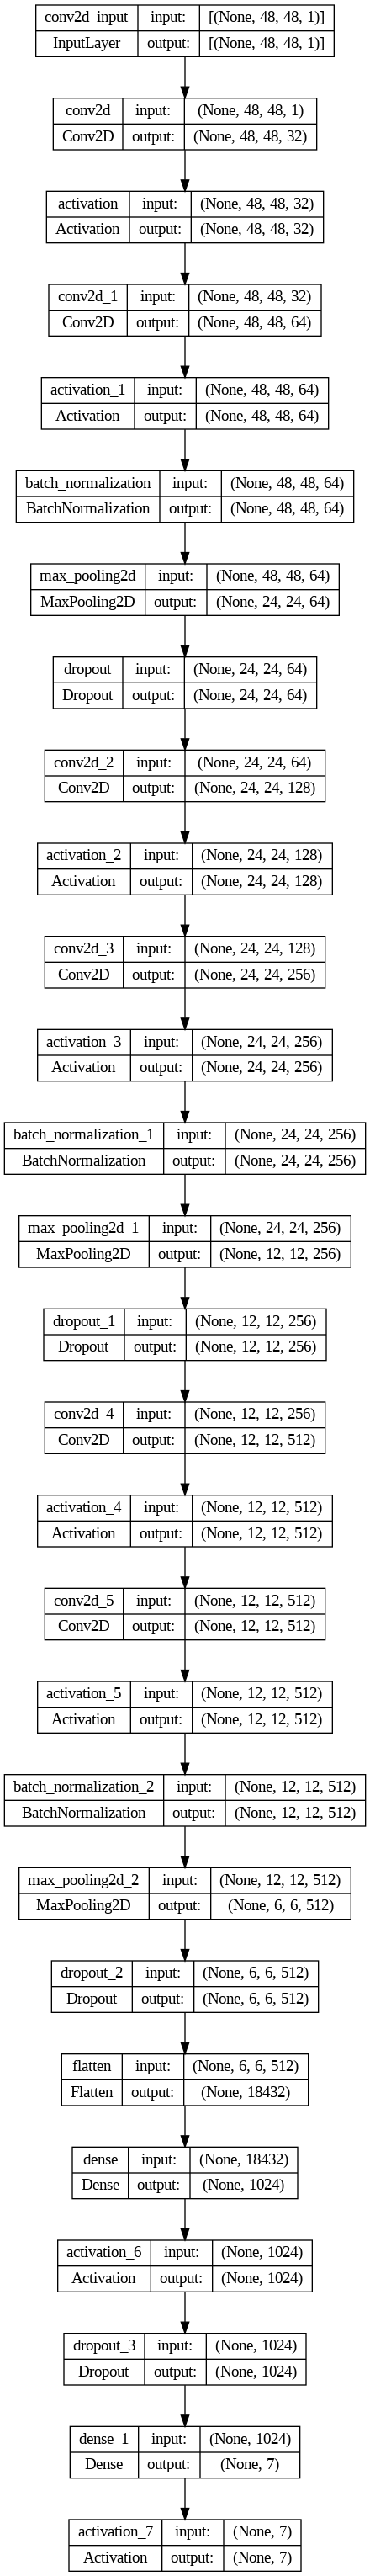

In [ ]:
plot_model(model,to_file = "/content/FER_2013_Emotion_Detection/Custom_CNN_From_Scratch/Architecture.png",
           show_shapes = True,show_layer_names = True)

In [ ]:
# callbacks in cnn
# i want that best hyperparameters during training get stored somewhere in some directory
cnn_path = "/content/FER_2013_Emotion_Detection/Custom_CNN_From_Scratch"
name = "custm_CNN_model.keras"
chk_path = os.path.join(cnn_path,name)
chk_path

'/content/FER_2013_Emotion_Detection/Custom_CNN_From_Scratch/custm_CNN_model.keras'

In [ ]:
# callback to sve modelcheck point
checkpoint = ModelCheckpoint(filepath = cnn_path,
                             save_best_only = True,
                             verbose = 1,
                             mode = 'min',
                             monitor = 'var_loss')

In [ ]:
# callback for early stopping
earlystop = EarlyStopping(monitor = "val_loss",
                          min_delta = 0,
                          patience = 3,
                          verbose = 1,
                          restore_best_weights = True)

In [ ]:
# call back for reducing learning rate
reduce_lr = ReduceLROnPlateau(monitor = "val_loss",
                              factor = 0.2,
                              patience = 6,
                              verbose = 1,
                              min_delta = 0.0001)

In [ ]:
# Callback to log training data to a CSV file
csv_logger = CSVLogger(os.path.join(cnn_path,'training.log'))


In [ ]:
# aggregating all backs  into a list
callbacks = [checkpoint,earlystop,reduce_lr,csv_logger]

In [ ]:
# model training
history = model.fit(train_generator,
                    epochs = 20,
                    validation_data = validation_generator,
                    callbacks = callbacks)

Epoch 1/20
359/359 [==============================] - ETA: 0s - loss: 12.1457 - accuracy: 0.3008

359/359 [==============================] - 40s 82ms/step - loss: 12.1457 - accuracy: 0.3008 - val_loss: 12.0327 - val_accuracy: 0.1864 - lr: 1.0000e-04
Epoch 2/20
359/359 [==============================] - ETA: 0s - loss: 9.5582 - accuracy: 0.3839

359/359 [==============================] - 26s 72ms/step - loss: 9.5582 - accuracy: 0.3839 - val_loss: 8.6266 - val_accuracy: 0.4041 - lr: 1.0000e-04
Epoch 3/20
359/359 [==============================] - ETA: 0s - loss: 7.3246 - accuracy: 0.4333

359/359 [==============================] - 26s 73ms/step - loss: 7.3246 - accuracy: 0.4333 - val_loss: 6.3978 - val_accuracy: 0.4508 - lr: 1.0000e-04
Epoch 4/20
359/359 [==============================] - ETA: 0s - loss: 5.5563 - accuracy: 0.4778

359/359 [==============================] - 26s 72ms/step - loss: 5.5563 - accuracy: 0.4778 - val_loss: 5.0785 - val_accuracy: 0.4581 - lr: 1.0000e-04
Epoch 5/20
359/359 [==============================] - ETA: 0s - loss: 4.2523 - accuracy: 0.5152

359/359 [==============================] - 26s 74ms/step - loss: 4.2523 - accuracy: 0.5152 - val_loss: 3.7978 - val_accuracy: 0.5165 - lr: 1.0000e-04
Epoch 6/20
359/359 [==============================] - ETA: 0s - loss: 3.3232 - accuracy: 0.5503

359/359 [==============================] - 29s 82ms/step - loss: 3.3232 - accuracy: 0.5503 - val_loss: 3.0829 - val_accuracy: 0.5175 - lr: 1.0000e-04
Epoch 7/20
359/359 [==============================] - ETA: 0s - loss: 2.6551 - accuracy: 0.5848

359/359 [==============================] - 26s 73ms/step - loss: 2.6551 - accuracy: 0.5848 - val_loss: 2.5335 - val_accuracy: 0.5454 - lr: 1.0000e-04
Epoch 8/20
359/359 [==============================] - ETA: 0s - loss: 2.1860 - accuracy: 0.6120

359/359 [==============================] - 27s 75ms/step - loss: 2.1860 - accuracy: 0.6120 - val_loss: 2.2578 - val_accuracy: 0.5508 - lr: 1.0000e-04
Epoch 9/20
359/359 [==============================] - ETA: 0s - loss: 1.8479 - accuracy: 0.6437

359/359 [==============================] - 26s 71ms/step - loss: 1.8479 - accuracy: 0.6437 - val_loss: 1.9782 - val_accuracy: 0.5609 - lr: 1.0000e-04
Epoch 10/20
359/359 [==============================] - ETA: 0s - loss: 1.5781 - accuracy: 0.6844

359/359 [==============================] - 26s 72ms/step - loss: 1.5781 - accuracy: 0.6844 - val_loss: 1.8433 - val_accuracy: 0.5665 - lr: 1.0000e-04
Epoch 11/20
359/359 [==============================] - ETA: 0s - loss: 1.3524 - accuracy: 0.7215

359/359 [==============================] - 26s 73ms/step - loss: 1.3524 - accuracy: 0.7215 - val_loss: 1.7871 - val_accuracy: 0.5494 - lr: 1.0000e-04
Epoch 12/20
359/359 [==============================] - ETA: 0s - loss: 1.1594 - accuracy: 0.7672

359/359 [==============================] - 26s 71ms/step - loss: 1.1594 - accuracy: 0.7672 - val_loss: 1.7324 - val_accuracy: 0.5776 - lr: 1.0000e-04
Epoch 13/20
359/359 [==============================] - ETA: 0s - loss: 1.0003 - accuracy: 0.8079

359/359 [==============================] - 26s 72ms/step - loss: 1.0003 - accuracy: 0.8079 - val_loss: 1.6519 - val_accuracy: 0.5766 - lr: 1.0000e-04
Epoch 14/20
359/359 [==============================] - ETA: 0s - loss: 0.8514 - accuracy: 0.8460

359/359 [==============================] - 26s 71ms/step - loss: 0.8514 - accuracy: 0.8460 - val_loss: 1.6726 - val_accuracy: 0.5853 - lr: 1.0000e-04
Epoch 15/20
359/359 [==============================] - ETA: 0s - loss: 0.7316 - accuracy: 0.8762

359/359 [==============================] - 26s 71ms/step - loss: 0.7316 - accuracy: 0.8762 - val_loss: 1.6367 - val_accuracy: 0.5957 - lr: 1.0000e-04
Epoch 16/20
359/359 [==============================] - ETA: 0s - loss: 0.6330 - accuracy: 0.9010

359/359 [==============================] - 26s 72ms/step - loss: 0.6330 - accuracy: 0.9010 - val_loss: 1.8017 - val_accuracy: 0.5769 - lr: 1.0000e-04
Epoch 17/20
359/359 [==============================] - ETA: 0s - loss: 0.5664 - accuracy: 0.9136

359/359 [==============================] - 26s 71ms/step - loss: 0.5664 - accuracy: 0.9136 - val_loss: 1.6581 - val_accuracy: 0.5957 - lr: 1.0000e-04
Epoch 18/20
359/359 [==============================] - ETA: 0s - loss: 0.5025 - accuracy: 0.9299

Restoring model weights from the end of the best epoch: 15.
359/359 [==============================] - 26s 72ms/step - loss: 0.5025 - accuracy: 0.9299 - val_loss: 1.6893 - val_accuracy: 0.5997 - lr: 1.0000e-04
Epoch 18: early stopping


In [19]:
# plotting performance matrices
def plot_training_history(history):
    """
    Plots the training and validation accuracy and loss.

    Parameters:
    - history: A Keras History object. Contains the logs from the training process.

    Returns:
    - None. Displays the matplotlib plots for training/validation accuracy and loss.
    """
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(len(acc))

    plt.figure(figsize=(20, 5))

    # Plot training and validation accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    # Plot training and validation loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

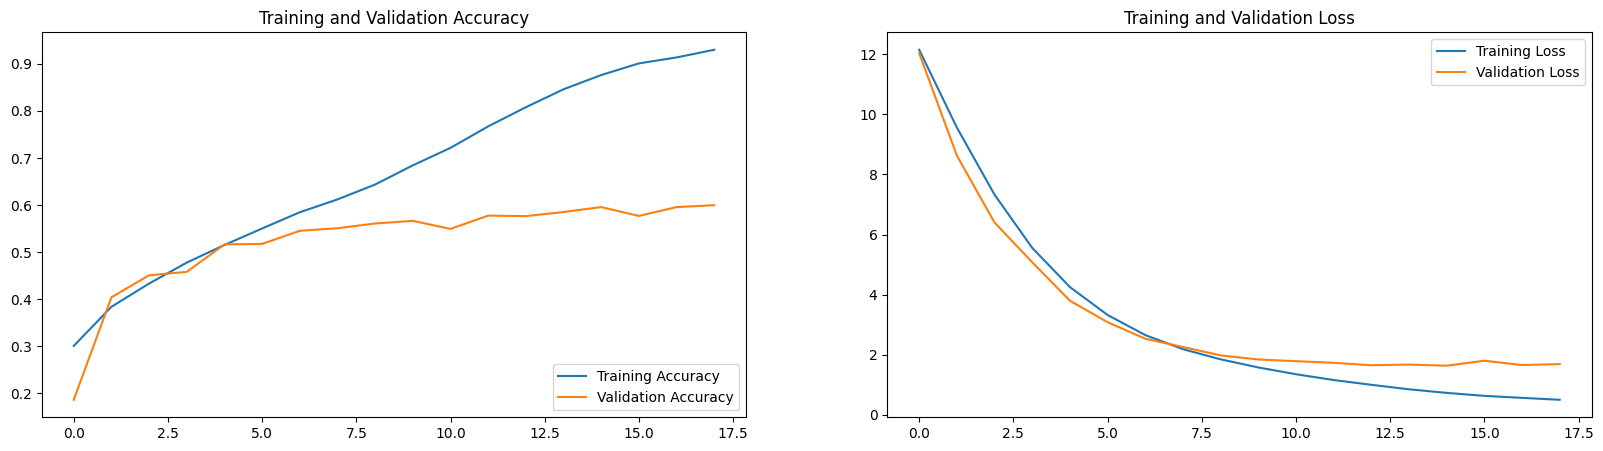

In [ ]:
plot_training_history(history)

In [ ]:
# model evaluation
train_loss,train_acc = model.evaluate(train_generator)
test_loss,test_acc = model.evaluate(test_generator)
print("  train accuracy = {:.2f},test_accuracy = {:.2f}".format(train_acc*100,test_acc*100))


113/113 [==============================] - 3s 27ms/step - loss: 1.5921 - accuracy: 0.6085
  train accuracy = 95.68,test_accuracy = 60.85


113/113 [==============================] - 2s 21ms/step


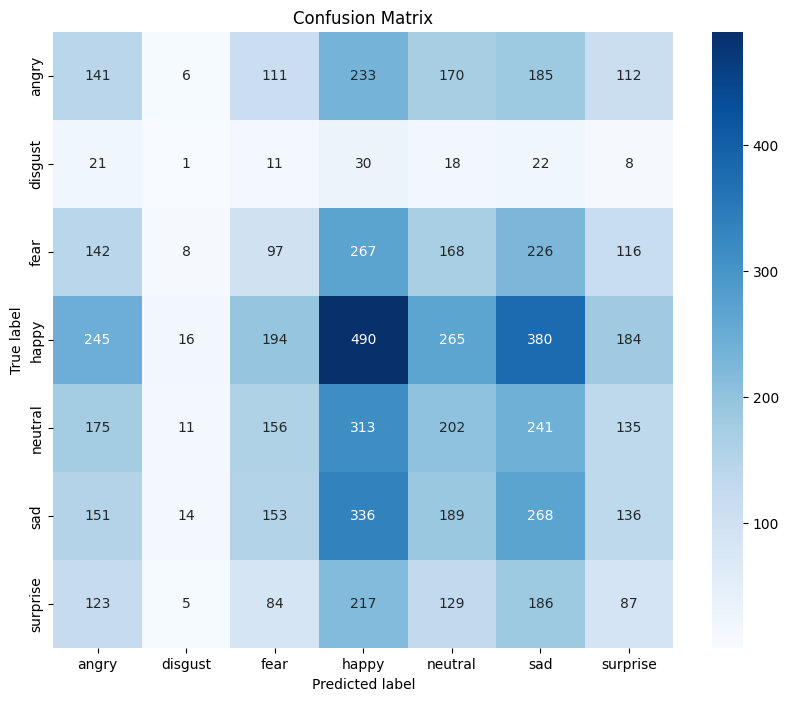

In [ ]:
# Assuming your true_classes and predicted_classes are already defined
true_classes = test_generator.classes
predicted_classes = np.argmax(model.predict(test_generator, steps=np.ceil(test_generator.samples/test_generator.batch_size)), axis=1)
class_labels = list(test_generator.class_indices.keys())

# Generate the confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Plotting with seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [ ]:
# Printing the classification report
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

       angry       0.14      0.15      0.14       958
     disgust       0.02      0.01      0.01       111
        fear       0.12      0.09      0.11      1024
       happy       0.26      0.28      0.27      1774
     neutral       0.18      0.16      0.17      1233
         sad       0.18      0.21      0.19      1247
    surprise       0.11      0.10      0.11       831

    accuracy                           0.18      7178
   macro avg       0.14      0.14      0.14      7178
weighted avg       0.17      0.18      0.18      7178



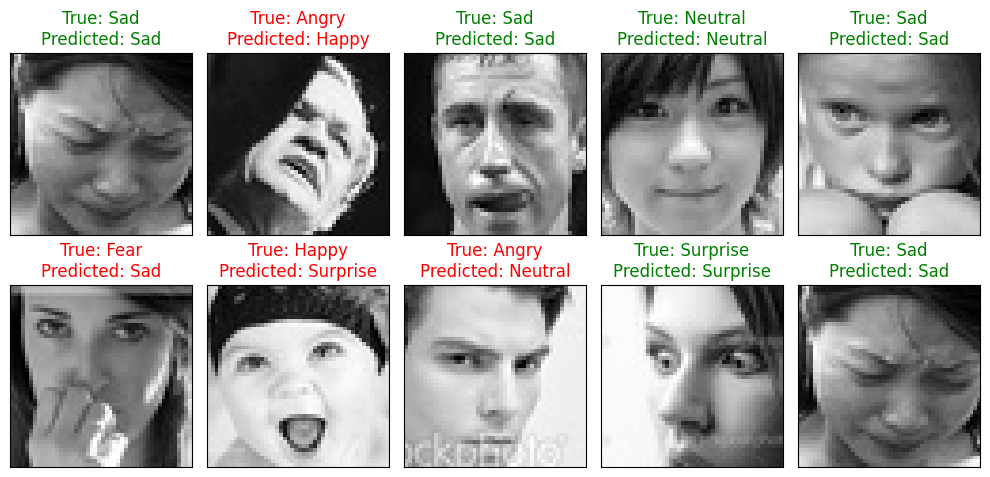

In [ ]:
# now finally making predictions using the CNN model which i have created
# Emotion classes for the dataset
Emotion_Classes = ['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise']

# Assuming test_generator and model are already defined
batch_size = test_generator.batch_size

# Selecting a random batch from the test generator
Random_batch = np.random.randint(0, len(test_generator) - 1)

# Selecting random image indices from the batch
Random_Img_Index = np.random.randint(0, batch_size, 10)

# Setting up the plot
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(10, 5),
                         subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    # Fetching the random image and its label
    Random_Img = test_generator[Random_batch][0][Random_Img_Index[i]]
    Random_Img_Label = np.argmax(test_generator[Random_batch][1][Random_Img_Index[i]], axis=0)

    # Making a prediction using the model
    Model_Prediction = np.argmax(model.predict(tf.expand_dims(Random_Img, axis=0), verbose=0), axis=1)[0]

    # Displaying the image
    ax.imshow(Random_Img.squeeze(), cmap='gray')  # Assuming the images are grayscale
    # Setting the title with true and predicted labels, colored based on correctness
    color = "green" if Emotion_Classes[Random_Img_Label] == Emotion_Classes[Model_Prediction] else "red"
    ax.set_title(f"True: {Emotion_Classes[Random_Img_Label]}\nPredicted: {Emotion_Classes[Model_Prediction]}", color=color)

plt.tight_layout()
plt.show()

In [ ]:
#2 now i will create cnn model by using image augmentation
train_data_dir = "/content/train"
test_data_dir = "/content/test"


# setting some parameters
image_width,image_height = 48,48
batch_size = 64
epochs = 10
num_classes = 7


# initailizing ImageDataGenerator along with data augmentation technique
data_generator = ImageDataGenerator(1./255,
                                    rotation_range = 40,
                                    width_shift_range = 0.2,
                                    height_shift_range = 0.2,
                                    shear_range = 0.2,
                                    zoom_range = 0.2,
                                    horizontal_flip = True,
                                    fill_mode = 'nearest',
                                    validation_split = 0.2)
# augmentation technique will not be used for testing data set
test_data_generator = ImageDataGenerator(1./255)

# Automatically retrieve images and their classes for train and validation sets
train_generator = data_generator.flow_from_directory(
    train_data_dir,
    target_size=(image_width, image_height),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale',
    subset='training')

validation_generator = data_generator.flow_from_directory(
    train_data_dir,
    target_size=(image_width, image_height),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale',
    subset='validation')

test_generator = test_data_generator.flow_from_directory(
    test_data_dir,
    target_size=(image_width, image_height),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale'
    )

Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


/usr/local/lib/python3.10/dist-packages/keras/src/preprocessing/image.py:1862: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(


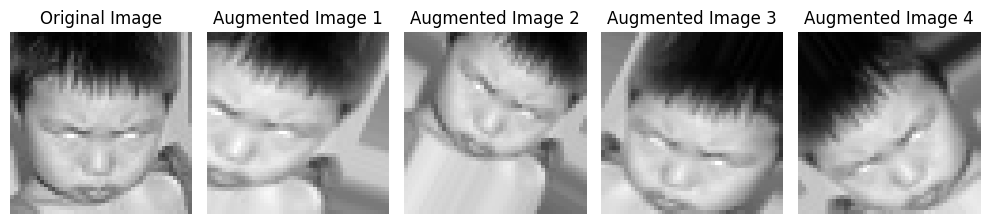

In [ ]:
# Path to your specific image
image_path = '/content/train/angry/Training_10118481.jpg'

# Load and convert the image to an array
img = load_img(image_path, color_mode='grayscale', target_size=(image_width, image_height))  # Adjust color_mode if necessary
img_array = img_to_array(img)  # Converts the image to a numpy array
img_array = img_array.reshape((1,) + img_array.shape)  # Reshapes the image to (1, width, height, channels) for the generator

# Setting up the plot
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(10, 4))
# Plot the original image first. Since img_array is a 3D array after reshaping, we use [:, :, 0]
axes[0].imshow(img_array[0, :, :, 0], cmap='gray')
axes[0].set_title('Original Image')
axes[0].axis('off')

# Generate and plot augmented images
for i, ax in enumerate(axes.flat[1:]):  # Start from the second subplot
    # Generate a batch of augmented images
    aug_iter = data_generator.flow(img_array, batch_size=1)
    aug_img = next(aug_iter)[0]  # Get the first augmented image from the batch
    # save image
    # Plot the augmented image. We directly use [:, :, 0] without an initial batch index
    ax.imshow(aug_img[:, :, 0], cmap='gray')
    ax.set_title(f'Augmented Image {i+1}')
    ax.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
# same CNN model as above
# Assuming img_width, img_height, and classes are defined. For example:
img_width, img_height = 48, 48
classes = 7

#Initialising the CNN
model = tf.keras.models.Sequential()

# Adding convolutional layers with activations on separate lines
# same code as above
model.add(Conv2D(32, kernel_size=(3, 3), padding='same', input_shape=(img_width, img_height, 1)))
model.add(tf.keras.layers.Activation('relu'))
model.add(Conv2D(64, kernel_size=(3, 3), padding='same'))
model.add(tf.keras.layers.Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(2, 2))
model.add(Dropout(0.25))

model.add(Conv2D(128, kernel_size=(3, 3), padding='same', kernel_regularizer=regularizers.l2(0.01)))
model.add(tf.keras.layers.Activation('relu'))
model.add(Conv2D(256, kernel_size=(3, 3), kernel_regularizer=regularizers.l2(0.01)))
model.add(tf.keras.layers.Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(512, kernel_size=(3, 3), padding='same', kernel_regularizer=regularizers.l2(0.01)))
model.add(tf.keras.layers.Activation('relu'))
model.add(Conv2D(512, kernel_size=(3, 3), padding='same', kernel_regularizer=regularizers.l2(0.01)))
model.add(tf.keras.layers.Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Flattening and adding dense layers
model.add(Flatten())
model.add(Dense(1024))
model.add(tf.keras.layers.Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(classes))
model.add(tf.keras.layers.Activation('softmax'))

# Compiling the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])


# File path for the model checkpoint
cnn_path = '/content/FER_2013_Emotion_Detection/Custom_CNN_With_Augmentation'
name = 'Custom_CNN_augmented_model.keras'
chk_path = os.path.join(cnn_path, name)

# Callback to save the model checkpoint
checkpoint = ModelCheckpoint(filepath=chk_path,
                             save_best_only=True,
                             verbose=1,
                             mode='min',
                             monitor='val_loss')

# Callback for early stopping
earlystop = EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=3,
                          verbose=1,
                          restore_best_weights=True)

# Callback to reduce learning rate
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=6,
                              verbose=1,
                              min_delta=0.0001)

# Callback to log training data to a CSV file
csv_logger = CSVLogger(os.path.join(cnn_path,'training.log'))

# Aggregating all callbacks into a list
callbacks = [checkpoint, earlystop, reduce_lr, csv_logger]  # Adjusted as per your use-case

train_steps_per_epoch = train_generator.samples // train_generator.batch_size + 1
validation_steps_epoch = validation_generator.samples // validation_generator.batch_size + 1
test_steps_epoch = test_generator.samples // test_generator.batch_size + 1

history = model.fit(
    train_generator,
    steps_per_epoch=train_steps_per_epoch,
    epochs=100,
    validation_data=validation_generator,
    validation_steps=validation_steps_epoch,
    callbacks=callbacks)

Epoch 1/100
359/359 [==============================] - ETA: 0s - loss: 12.5596 - accuracy: 0.2218
Epoch 1: val_loss improved from inf to 11.82737, saving model to /content/FER_2013_Emotion_Detection/Custom_CNN_With_Augmentation/Custom_CNN_augmented_model.keras
359/359 [==============================] - 48s 117ms/step - loss: 12.5596 - accuracy: 0.2218 - val_loss: 11.8274 - val_accuracy: 0.2529 - lr: 1.0000e-04
Epoch 2/100
359/359 [==============================] - ETA: 0s - loss: 10.3916 - accuracy: 0.2427
Epoch 2: val_loss improved from 11.82737 to 9.44768, saving model to /content/FER_2013_Emotion_Detection/Custom_CNN_With_Augmentation/Custom_CNN_augmented_model.keras
359/359 [==============================] - 37s 102ms/step - loss: 10.3916 - accuracy: 0.2427 - val_loss: 9.4477 - val_accuracy: 0.2545 - lr: 1.0000e-04
Epoch 3/100
359/359 [==============================] - ETA: 0s - loss: 8.3011 - accuracy: 0.2506
Epoch 3: val_loss improved from 9.44768 to 7.68564, saving model to /con

In [ ]:
train_loss, train_accu = model.evaluate(train_generator)
test_loss, test_accu = model.evaluate(test_generator)
print("final train accuracy = {:.2f} , validation accuracy = {:.2f}".format(train_accu*100, test_accu*100))

113/113 [==============================] - 3s 25ms/step - loss: 1.2413 - accuracy: 0.5793
final train accuracy = 57.69 , validation accuracy = 57.93


113/113 [==============================] - 3s 29ms/step


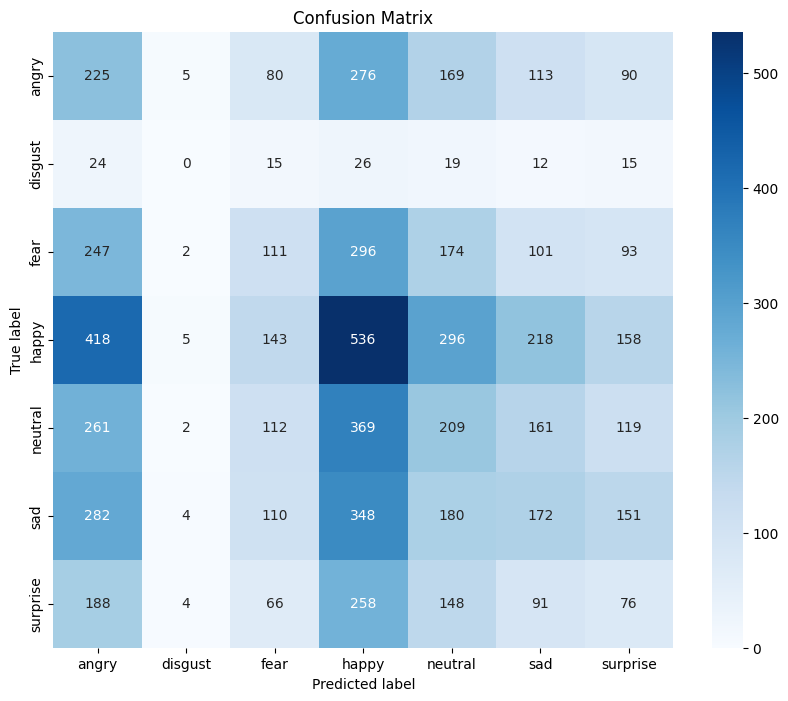

In [ ]:
# Assuming your true_classes and predicted_classes are already defined
true_classes = test_generator.classes
predicted_classes = np.argmax(model.predict(test_generator, steps=np.ceil(test_generator.samples/test_generator.batch_size)), axis=1)
class_labels = list(test_generator.class_indices.keys())

# Generate the confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Plotting with seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [ ]:
# Printing the classification report
report = classification_report(true_classes,
                               predicted_classes,
                               target_names=class_labels,
                               zero_division=0)
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

       angry       0.14      0.23      0.17       958
     disgust       0.00      0.00      0.00       111
        fear       0.17      0.11      0.13      1024
       happy       0.25      0.30      0.28      1774
     neutral       0.17      0.17      0.17      1233
         sad       0.20      0.14      0.16      1247
    surprise       0.11      0.09      0.10       831

    accuracy                           0.19      7178
   macro avg       0.15      0.15      0.15      7178
weighted avg       0.18      0.19      0.18      7178



In [ ]:
# now we will create our CNN model by using the transfer learning
# first we will use VGGNET
# Define paths to the train and validation directories
train_data_dir = '/content/train'
test_data_dir = '/content/test'


# Set some parameters
img_width, img_height = 224, 224  # Size of images
batch_size = 64
epochs = 10
num_classes = 7  # Update this based on the number of your classes

# Rescale the pixel values (0-255) to the [0, 1] interval
data_generator = ImageDataGenerator(
                                rescale = 1 / 255.,
                                rotation_range=10,
                                zoom_range=0.2,
                                width_shift_range=0.1,
                                height_shift_range=0.1,
                                horizontal_flip=True,
                                fill_mode='nearest'

                                )

test_preprocessor = ImageDataGenerator(
    rescale = 1 / 255.,
)

# Automatically retrieve images and their classes for train and validation sets
train_generator = data_generator.flow_from_directory(
                                train_data_dir,
                                target_size=(img_width, img_height),
                                batch_size=batch_size,
                                class_mode='categorical',
                                color_mode='rgb',
                                subset='training',
                                shuffle = True)

test_generator = test_preprocessor.flow_from_directory(
                                test_data_dir,
                                target_size=(img_width, img_height),
                                batch_size=batch_size,
                                class_mode='categorical',
                                color_mode='rgb',)
                                # subset='validation')

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [ ]:
# from data visualisation there is data imbalance
# so to create a best model we need to ensure that our data must be balanced
# as we cannot change our data, we have to work on the data given to us
# so will ensure that every class in image dataset will be considered equally , not on the basis of its quantity
# in order to make my model best


classes = np.array(train_generator.classes)
class_weights = compute_class_weight(
    class_weight = 'balanced',
    classes = np.unique(classes),
    y = classes

)
class_weight_dict = dict(enumerate(class_weights))
print(class_weight_dict)


{0: 1.0266046844269623, 1: 9.406618610747051, 2: 1.0010460615781582, 3: 0.5684387684387684, 4: 0.8260394187886635, 5: 0.8491274770777877, 6: 1.293372978330405}


In [ ]:
# clear the previous tensorflow sessionx
tf.keras.backend.clear_session()
# loading the VGG16 model excluding its fullyconnected layers or Dense layers
vgg = VGG16(input_shape = (224,224,3),include_top = False,weights = 'imagenet')
vgg.summary()

58889256/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                              

In [ ]:
# making the specified layers non trainable

for layer in vgg.layers[:-3]:
    layer.trainable = False

vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
# flattening the layers and adding custom dense layers
x = Flatten()(vgg.output)
x = Dense(1024,activation = 'relu',kernel_initializer = 'he_normal')(x)
x = Dropout(0.5)(x)

x = Dense(512,activation = 'relu',kernel_initializer = 'he_normal')(x)
x = Dropout(0.5)(x)

# adding the output layer with softmax activation
output = Dense(7,activation = "softmax",kernel_initializer = "he_normal")(x)


# now creating the model
model = Model(inputs = vgg.input,outputs = output)

# compile the model
model.compile(loss = "categorical_crossentropy",

              optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001,beta_1 = 0.9,beta_2 = 0.999,amsgrad = False))


model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
# now creating callbacks for my model
cnn_path = "/content/FER_2013_Emotion_Detection/VGG16_Transfer_Learning"
name = "VGG16_Transfer_learning.keras"
chk_path = os.path.join(cnn_path,name)

# callback to save modecheckpoint
checkpoint = ModelCheckpoint(filepath=chk_path,
                             save_best_only=True,
                             verbose=1,
                             mode='min',
                             monitor='val_loss')

# Callback for early stopping
earlystop = EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=3,
                          verbose=1,
                          restore_best_weights=True)

# Callback to reduce learning rate
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=6,
                              verbose=1,
                              min_delta=0.0001)

# Callback to log training data to a CSV file
csv_logger = CSVLogger(os.path.join(cnn_path,'training.log'))

# Aggregating all callbacks into a list
callbacks = [checkpoint, earlystop, reduce_lr, csv_logger]  # Adjusted as per your use-case

train_steps_per_epoch = train_generator.samples // train_generator.batch_size + 1
# validation_steps_epoch = validation_generator.samples // validation_generator.batch_size + 1
test_steps_epoch = test_generator.samples // test_generator.batch_size + 1

In [ ]:
history = model.fit(
                    train_generator,
                    steps_per_epoch=train_steps_per_epoch,
                    epochs=100,
                    validation_data=test_generator,
                    validation_steps=test_steps_epoch,
                    class_weight=class_weight_dict,
                    callbacks = callbacks
                    )

Epoch 1/100
449/449 [==============================] - ETA: 0s - loss: 1.8113
Epoch 1: val_loss improved from inf to 1.54691, saving model to /content/FER_2013_Emotion_Detection/VGG16_Transfer_Learning/VGG16_Transfer_learning.keras
449/449 [==============================] - 446s 961ms/step - loss: 1.8113 - val_loss: 1.5469 - lr: 1.0000e-04
Epoch 2/100
449/449 [==============================] - ETA: 0s - loss: 1.5874
Epoch 2: val_loss improved from 1.54691 to 1.39092, saving model to /content/FER_2013_Emotion_Detection/VGG16_Transfer_Learning/VGG16_Transfer_learning.keras
449/449 [==============================] - 421s 937ms/step - loss: 1.5874 - val_loss: 1.3909 - lr: 1.0000e-04
Epoch 3/100
449/449 [==============================] - ETA: 0s - loss: 1.4716
Epoch 3: val_loss improved from 1.39092 to 1.36491, saving model to /content/FER_2013_Emotion_Detection/VGG16_Transfer_Learning/VGG16_Transfer_learning.keras
449/449 [==============================] - 426s 948ms/step - loss: 1.4716 - 

In [ ]:
plot_training_history(history)

In [ ]:
train_loss, train_accu = model.evaluate(train_generator)
test_loss, test_accu = model.evaluate(test_generator)
print("final train accuracy = {:.2f} , validation accuracy = {:.2f}".format(train_accu*100, test_accu*100))

In [ ]:
# Assuming your true_classes and predicted_classes are already defined
true_classes = test_generator.classes
predicted_classes = np.argmax(model.predict(test_generator, steps=np.ceil(test_generator.samples/test_generator.batch_size)), axis=1)
class_labels = list(test_generator.class_indices.keys())

# Generate the confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Plotting with seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [ ]:
# Printing the classification report
report = classification_report(true_classes,
                               predicted_classes,
                               target_names=class_labels,
                               zero_division=0)
print("Classification Report:\n", report)

In [7]:
# now i will use RESNet50 as a transfer learning model
train_dir = "/content/train"
test_dir = "/content/test"


# batch size
batch_size = 64

train_data_generator = ImageDataGenerator(rescale = 1/255,
                                          rotation_range = 10,
                                          zoom_range = 0.2,
                                          width_shift_range = 0.1,
                                          height_shift_range = 0.1,
                                          horizontal_flip = True,
                                          fill_mode = "nearest"
                                          )
test_data_generator = ImageDataGenerator(rescale = 1/255.)
# Data generators for training and testing data
train_generator = train_data_generator.flow_from_directory(
                                                    train_dir,  # Directory containing training data
                                                    class_mode="categorical",  # Classification mode for categorical labels
                                                    target_size=(224, 224),  # Resize input images to (224,224)
                                                    color_mode='rgb',  # Color mode for images (RGB)
                                                    shuffle=True,  # Shuffle training data
                                                    batch_size=batch_size,  # Batch size for training
                                                    subset='training'  # Subset of data (training)
                                                   )

test_generator = test_data_generator.flow_from_directory(
                                                  test_dir,  # Directory containing testing data
                                                  class_mode="categorical",  # Classification mode for categorical labels
                                                  target_size=(224, 224),  # Resize input images to (224,224)
                                                  color_mode="rgb",  # Color mode for images (RGB)
                                                  shuffle=False,  # Do not shuffle testing data
                                                  batch_size=batch_size  # Batch size for testing
                                                 )




Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [8]:
# for working on imabalnce data
# Extract class labels for all instances in the training dataset
classes = np.array(train_generator.classes)

# Calculate class weights to handle imbalances in the training data
# 'balanced' mode automatically adjusts weights inversely proportional to class frequencies
class_weights = compute_class_weight(
    class_weight='balanced',  # Strategy to balance classes
    classes=np.unique(classes),  # Unique class labels
    y=classes  # Class labels for each instance in the training dataset
)

# Create a dictionary mapping class indices to their calculated weights
class_weights_dict = dict(enumerate(class_weights))

# Output the class weights dictionary
print("Class Weights Dictionary:", class_weights_dict)

Class Weights Dictionary: {0: 1.0266046844269623, 1: 9.406618610747051, 2: 1.0010460615781582, 3: 0.5684387684387684, 4: 0.8260394187886635, 5: 0.8491274770777877, 6: 1.293372978330405}


In [9]:
ResNet50V2 = tf.keras.applications.ResNet50V2(input_shape=(224, 224, 3),
                                               include_top= False,
                                               weights='imagenet'
                                               )

94668760/94668760 [==============================] - 6s 0us/step


In [10]:
# freezing all layers except last 50

ResNet50V2.trainable = True

for layer in ResNet50V2.layers[:-50]:
    layer.trainable = False

In [11]:
def Create_ResNet50V2_Model():

    model = Sequential([
                      ResNet50V2,
                      Dropout(0.25),
                      BatchNormalization(),
                      Flatten(),
                      Dense(64, activation='relu'),
                      BatchNormalization(),
                      Dropout(0.5),
                      Dense(7,activation='softmax')
                    ])
    return model

In [12]:
ResNet50V2.summary()

Model: "resnet50v2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 pool1_pad (ZeroPadding2D)   (None, 114, 114, 64)         0         ['conv1_conv[0][0]']          
                                                                                         

In [13]:
model = Create_ResNet50V2_Model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 7, 7, 2048)        23564800  
                                                                 
 dropout (Dropout)           (None, 7, 7, 2048)        0         
                                                                 
 batch_normalization (Batch  (None, 7, 7, 2048)        8192      
 Normalization)                                                  
                                                                 
 flatten (Flatten)           (None, 100352)            0         
                                                                 
 dense (Dense)               (None, 64)                6422592   
                                                                 
 batch_normalization_1 (Bat  (None, 64)                256       
 chNormalization)                                       

In [14]:
model.compile(loss = 'categorical_crossentropy',optimizer = 'adam',metrics = ["accuracy"])

In [15]:
# File path for the model checkpoint
cnn_path = '/content/FER_2013_Emotion_Detection/ResNet50_Transfer_Learning'
name = 'ResNet50_Transfer_Learning.keras'
chk_path = os.path.join(cnn_path, name)

# Callback to save the model checkpoint
checkpoint = ModelCheckpoint(filepath=chk_path,
                             save_best_only=True,
                             verbose=1,
                             mode='min',
                             monitor='val_loss')

# Callback for early stopping
earlystop = EarlyStopping(monitor = 'val_accuracy',
                          patience = 7,
                          restore_best_weights = True,
                          verbose=1)

# Callback to reduce learning rate
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=2,
#                             min_lr=0.00005,
                              verbose=1)

# Callback to log training data to a CSV file
csv_logger = CSVLogger(os.path.join(cnn_path,'training.log'))

# Aggregating all callbacks into a list
callbacks = [checkpoint, earlystop, csv_logger]  # Adjusted as per your use-case

train_steps_per_epoch = train_generator.samples // train_generator.batch_size + 1
# validation_steps_epoch = validation_generator.samples // validation_generator.batch_size + 1
test_steps_epoch = test_generator.samples // test_generator.batch_size + 1

In [17]:
train_history = model.fit(
                          train_generator,
                          steps_per_epoch=train_steps_per_epoch,
                          epochs=40,
                          validation_data=test_generator,
                          validation_steps=test_steps_epoch,
                          class_weight=class_weights_dict,
                          callbacks = callbacks
                         )

Epoch 1/40
449/449 [==============================] - ETA: 0s - loss: 1.7784 - accuracy: 0.3798
Epoch 1: val_loss improved from inf to 1.70262, saving model to /content/FER_2013_Emotion_Detection/ResNet50_Transfer_Learning/ResNet50_Transfer_Learning.keras
449/449 [==============================] - 315s 701ms/step - loss: 1.7784 - accuracy: 0.3798 - val_loss: 1.7026 - val_accuracy: 0.4733
Epoch 2/40
449/449 [==============================] - ETA: 0s - loss: 1.4453 - accuracy: 0.4581
Epoch 2: val_loss improved from 1.70262 to 1.36269, saving model to /content/FER_2013_Emotion_Detection/ResNet50_Transfer_Learning/ResNet50_Transfer_Learning.keras
449/449 [==============================] - 312s 694ms/step - loss: 1.4453 - accuracy: 0.4581 - val_loss: 1.3627 - val_accuracy: 0.4902
Epoch 3/40
449/449 [==============================] - ETA: 0s - loss: 1.3481 - accuracy: 0.4969
Epoch 3: val_loss did not improve from 1.36269
449/449 [==============================] - 312s 694ms/step - loss: 1.34

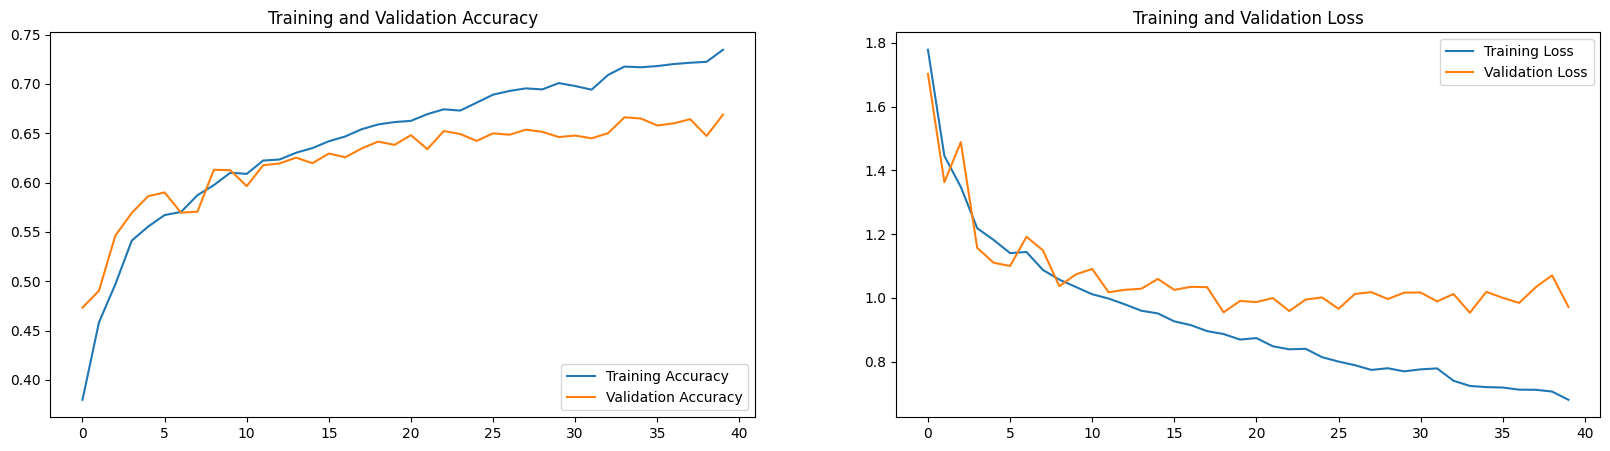

In [20]:
plot_training_history(train_history)

In [21]:
train_loss, train_accu = model.evaluate(train_generator)
test_loss, test_accu = model.evaluate(test_generator)
print("final train accuracy = {:.2f} , validation accuracy = {:.2f}".format(train_accu*100, test_accu*100))

113/113 [==============================] - 11s 99ms/step - loss: 0.9715 - accuracy: 0.6688
final train accuracy = 75.56 , validation accuracy = 66.88


113/113 [==============================] - 12s 96ms/step


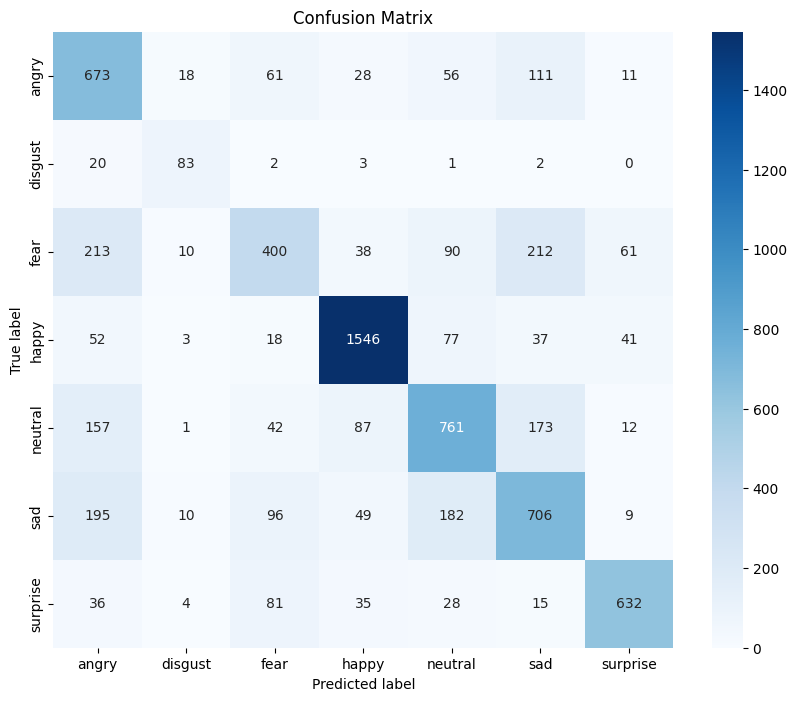

In [22]:
# Assuming your true_classes and predicted_classes are already defined
true_classes = test_generator.classes
predicted_classes = np.argmax(model.predict(test_generator, steps=np.ceil(test_generator.samples/test_generator.batch_size)), axis=1)
class_labels = list(test_generator.class_indices.keys())

# Generate the confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Plotting with seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [23]:
# Printing the classification report
report = classification_report(true_classes,
                               predicted_classes,
                               target_names=class_labels,
                               zero_division=0)
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

       angry       0.50      0.70      0.58       958
     disgust       0.64      0.75      0.69       111
        fear       0.57      0.39      0.46      1024
       happy       0.87      0.87      0.87      1774
     neutral       0.64      0.62      0.63      1233
         sad       0.56      0.57      0.56      1247
    surprise       0.83      0.76      0.79       831

    accuracy                           0.67      7178
   macro avg       0.66      0.67      0.66      7178
weighted avg       0.67      0.67      0.67      7178



In [ ]:
# now doing deployment of my model

In [26]:
 model = keras.saving.load_model("/content/FER_2013_Emotion_Detection/ResNet50_Transfer_Learning/ResNet50_Transfer_Learning.keras")

In [25]:
import keras

In [27]:
!cp /content/FER_2013_Emotion_Detection /content/drive/MyDrive/

cp: -r not specified; omitting directory '/content/FER_2013_Emotion_Detection'


In [28]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [29]:
!pip3 install gradio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 88.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.0/92.0 kB 14.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.3/316.3 kB 41.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 13.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.5/142.5 kB 22.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.8/8.8 MB 57.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.2/47.2 kB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.4/62.4 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 20.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 13.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.9/71.9 kB 12.8 MB/

In [30]:
import numpy as np
from tensorflow.keras.preprocessing.image import img_to_array, load_img
import gradio as gr
import gradio as gr
import tensorflow as tf
import numpy as np
from PIL import Image
import cv2
from tensorflow.keras.preprocessing import image

In [31]:
model = tf.keras.models.load_model('/content/drive/MyDrive/Emotion_Detection/Final_Resnet50_Best_model.keras')

OSError: No file or directory found at /content/drive/MyDrive/Emotion_Detection/Final_Resnet50_Best_model.keras

In [32]:
# Emotion labels dictionary
emotion_labels = {'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}
index_to_emotion = {v: k for k, v in emotion_labels.items()}
index_to_emotion

{0: 'angry',
 1: 'disgust',
 2: 'fear',
 3: 'happy',
 4: 'neutral',
 5: 'sad',
 6: 'surprise'}

In [33]:
def prepare_image(img_pil):
    """Preprocess the PIL image to fit your model's input requirements."""
    # Convert the PIL image to a numpy array with the target size
    img = img_pil.resize((224, 224))
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Convert single image to a batch.
    img_array /= 255.0  # Rescale pixel values to [0,1], as done during training
    return img_array



# Define the Gradio interface
def predict_emotion(image):
    # Preprocess the image
    processed_image = prepare_image(image)
    # Make prediction using the model
    prediction = model.predict(processed_image)
    # Get the emotion label with the highest probability
    predicted_class = np.argmax(prediction, axis=1)
    predicted_emotion = index_to_emotion.get(predicted_class[0], "Unknown Emotion")
    return predicted_emotion

interface = gr.Interface(
    fn=predict_emotion,  # Your prediction function
    inputs=gr.Image(type="pil"),  # Input for uploading an image, directly compatible with PIL images
    outputs="text",  # Output as text displaying the predicted emotion
    title="Emotion Detection",
    description="Upload an image and see the predicted emotion."
)

# Launch the Gradio interface
interface.launch()


Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://68b8b6a62ed8f5a0c2.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


# New Section